In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [28]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")

## Imbalanced class problem

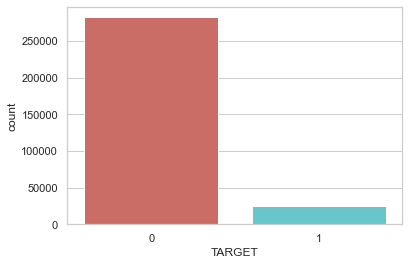

In [5]:
train.TARGET.value_counts()
sns.countplot(x='TARGET', data= train, palette='hls')

In [6]:
count_loan_repaid = len(train[train['TARGET']==0])
count_loan_no_repaid = len(train[train['TARGET']==1])
pct_of_loan_repaid = count_loan_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was repaid in the percentage of ", round(pct_of_loan_repaid*100, 2), '%')
pct_of_loan_no_repaid = count_loan_no_repaid/(count_loan_no_repaid+count_loan_repaid)
print("The loan was not repaid in the percentage of ", round(pct_of_loan_no_repaid*100,2), '%')

The loan was repaid in the percentage of  91.93 %
The loan was not repaid in the percentage of  8.07 %


The plot above shows the we are delaing with an imbalanced class problem, in particular the ratio of repaid-loans to no-repaid-loan is 92:8.

In [7]:
train.groupby('TARGET').mean()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
TARGET,,,,,,,,,,,,,,,,,,,,,
0,278244.744536,0.412946,169077.722266,602648.282002,27163.623349,542736.795003,0.021021,-16138.176397,65696.146123,-5029.941065,...,0.008341,0.000605,0.000506,0.000315,0.006380,0.006914,0.034315,0.270697,0.265939,1.889199
1,277449.167936,0.463807,165611.760906,557778.527674,26481.744290,488972.412554,0.019131,-14884.828077,42394.675448,-4487.127009,...,0.005720,0.000483,0.000524,0.000564,0.006672,0.008036,0.034919,0.227926,0.259923,2.028783


## Missing values

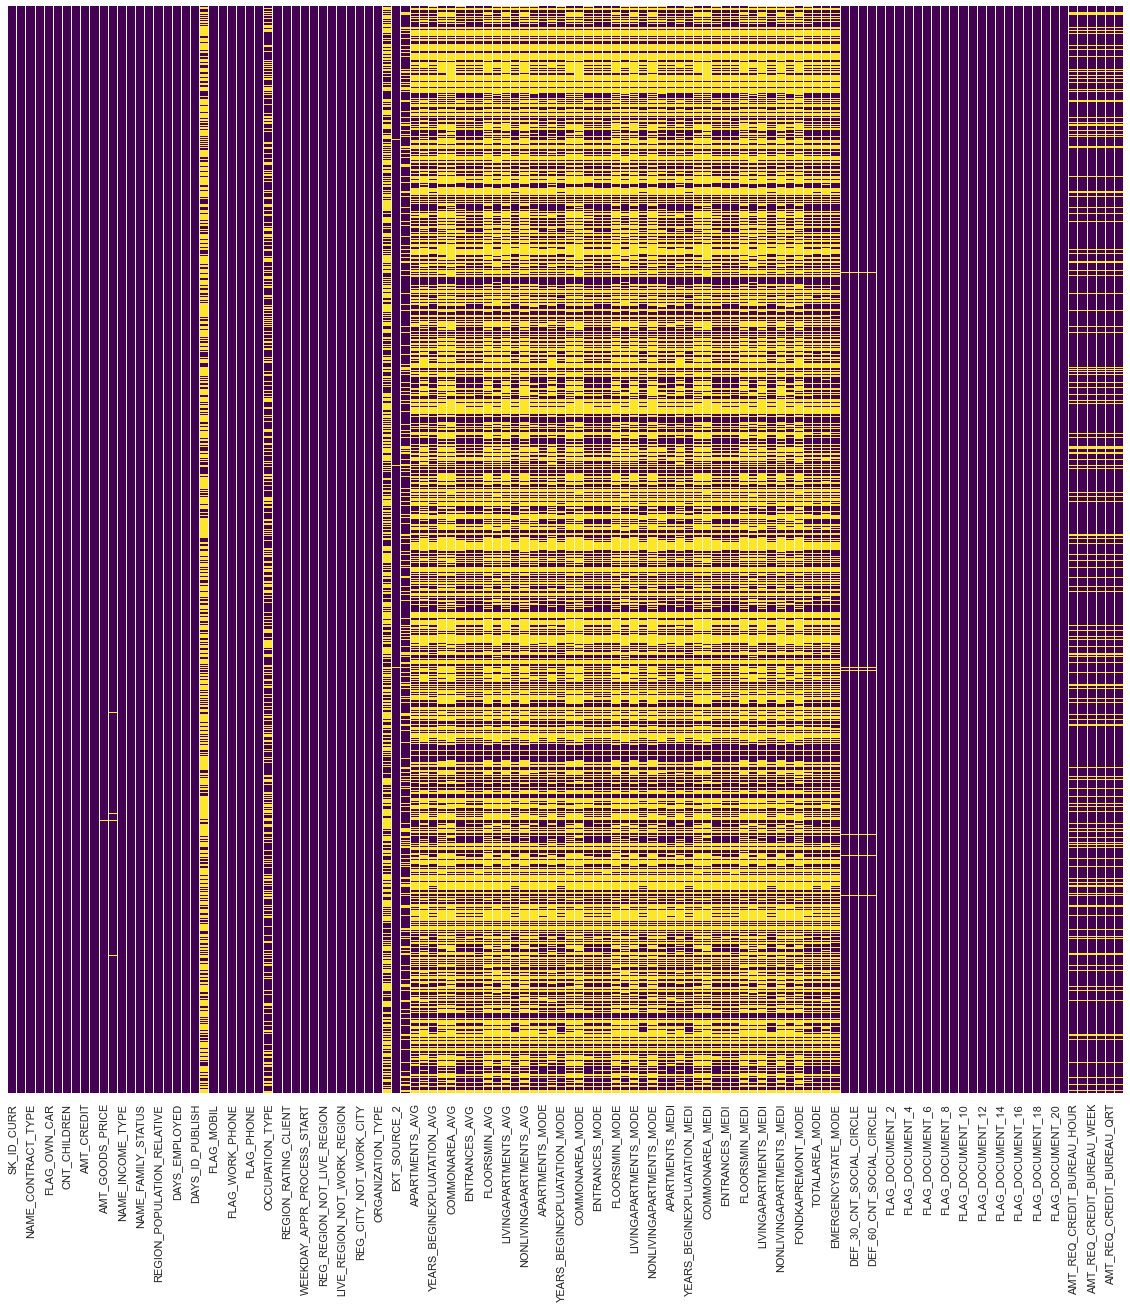

In [8]:
missing_values = train.isnull()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(data = missing_values, yticklabels=False, cbar=False, cmap='viridis', ax=ax)

In [9]:
def summary_missing_values(df):
    mising_values_sum = df.isnull().sum()
    mising_values_percentage = 100 * df.isnull().sum() / len(df)
    summary = pd.concat([mising_values_sum, mising_values_percentage], axis=1)
    summary.columns = ['Number of missing values','Percentage of missing values']    
    return summary.sort_values(by=['Percentage of missing values'], ascending=False)    

In [10]:
table_missing_values = summary_missing_values(train)

In [11]:
table_missing_values.head(20)

,Number of missing values,Percentage of missing values
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


Before building our model, we either have to fill all the missing values or drop the columns with a high percentage of missing values.

## Feature selection

In [29]:
correlations = train.corr()['TARGET'].sort_values()
pos_corr = correlations[correlations.values >= 0].sort_values(ascending=False)
neg_corr = correlations[correlations.values < 0]

In [30]:
most_neg_features = list(neg_corr.head(10).index)
most_pos_features = list(pos_corr.head(10).index)

In [32]:
len(table_missing_values)

122

In [33]:
table_missingValues_corr = pd.concat([table_missing_values, correlations], axis=1, sort=False).sort_values(by=['Percentage of missing values'], ascending=False)
table_missingValues_corr[table_missingValues_corr['Percentage of missing values']> 50]
table_missingValues_corr[table_missingValues_corr.index.isin(most_pos_features)].sort_values(by=['TARGET'], ascending=False)

,Number of missing values,Percentage of missing values,TARGET
TARGET,0,0.000000,1.000000
DAYS_BIRTH,0,0.000000,0.078239
REGION_RATING_CLIENT_W_CITY,0,0.000000,0.060893
REGION_RATING_CLIENT,0,0.000000,0.058899
DAYS_LAST_PHONE_CHANGE,1,0.000325,0.055218
DAYS_ID_PUBLISH,0,0.000000,0.051457
REG_CITY_NOT_WORK_CITY,0,0.000000,0.050994
FLAG_EMP_PHONE,0,0.000000,0.045982
REG_CITY_NOT_LIVE_CITY,0,0.000000,0.044395
FLAG_DOCUMENT_3,0,0.000000,0.044346


In [53]:
# Create a list with just the features we want to keep to build our model
# First, we select the first 3 with highest positive correlation, which also have no missing values. Note that the correlation is anyway very week..
selected_features = ['TARGET','DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT']

In [35]:
table_missingValues_corr[table_missingValues_corr.index.isin(most_neg_features)].sort_values(by=['TARGET'])

,Number of missing values,Percentage of missing values,TARGET
EXT_SOURCE_3,60965,19.825307,-0.178919
EXT_SOURCE_2,660,0.214626,-0.160472
EXT_SOURCE_1,173378,56.381073,-0.155317
DAYS_EMPLOYED,0,0.000000,-0.044932
FLOORSMAX_AVG,153020,49.760822,-0.044003
FLOORSMAX_MEDI,153020,49.760822,-0.043768
FLOORSMAX_MODE,153020,49.760822,-0.043226
AMT_GOODS_PRICE,278,0.090403,-0.039645
REGION_POPULATION_RELATIVE,0,0.000000,-0.037227
ELEVATORS_AVG,163891,53.295980,-0.034199


In [54]:
selected_features += ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_EMPLOYED']

We need to fill all the missing values before continuing

In [37]:
medianEX1 = train['EXT_SOURCE_1'].median()
train['EXT_SOURCE_1'].fillna(medianEX1, inplace=True)
medianEX2 = train['EXT_SOURCE_2'].median()
train['EXT_SOURCE_2'].fillna(medianEX2, inplace=True)
medianEX3 = train['EXT_SOURCE_3'].median()
train['EXT_SOURCE_3'].fillna(medianEX3, inplace=True)

In [55]:
reduced_train = train[selected_features]

## Categorical columns

In [39]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

We have to encode all the categorical variables, i.e. columns of 'object' type. We use the Label Encoder method for those having only 2 unique categories, One-Hot encoding for the rest:

In [41]:
# Label Encoder
le = LabelEncoder()
for column in train:
    if train[column].dtype == 'object' and len(list(train[column].unique())) <= 2:
        le.fit(train[column])
        train[column] = le.transform(train[column])
        test[column] = le.transform(test[column])

In [42]:
# One-hot encoding
categorical_variable_list = list(train.select_dtypes(include=['object']).columns)
for column in categorical_variable_list:
    encoded_column = pd.get_dummies(train[column], drop_first=True)
    train = pd.concat([train, encoded_column], axis=1)
    test = pd.concat([test, encoded_column], axis=1)

In [43]:
train.dtypes.value_counts()

uint8      121
float64     65
int64       41
object      13
int32        3
dtype: int64

## SMOTE algorithm

In [56]:
X = np.array(reduced_train.iloc[:, reduced_train.columns != 'TARGET'])
y = np.array(reduced_train.iloc[:, reduced_train.columns == 'TARGET'])

In [59]:
print(X.shape, '\n', y.shape)

(307511, 7) 
 (307511, 1)


In [72]:
X = reduced_train
y = train.loc[:, train.columns == 'TARGET']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_data_X, os_data_y=os.fit_sample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['TARGET'])
# we can Check the numbers of our data
print('After OverSampling, the shape of train_X: {}'.format(os_data_X.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(os_data_y.shape))

print("After OverSampling, counts of label '1': {}".format(os_data_y['TARGET'].value_counts()[1]))
print("After OverSampling, counts of label '0': {}".format(os_data_y['TARGET'].value_counts()[0]))

After OverSampling, the shape of train_X: (565372, 7)
After OverSampling, the shape of train_y: (565372, 1) 

After OverSampling, counts of label '1': 282686
After OverSampling, counts of label '0': 282686


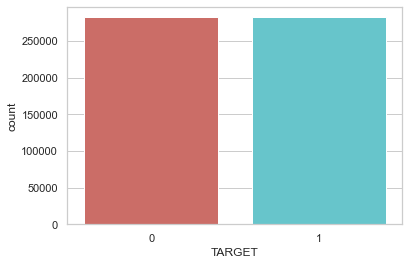

In [68]:
os_data_y.TARGET.value_counts()
sns.countplot(x='TARGET', data= os_data_y, palette='hls')

Now our data is balanced!